In [1]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms
import copy

import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import math

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture

from skimage.filters import sobel
from skimage.color import rgb2gray

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [2]:
#We mount the google drive. If You are running this notebook locally do nott run this cell. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET = "Allele B Cropped"
#X_PATH = "/content/drive/Shareddrives/Exploding Gradients/x_train_b.npy"
X_PATH = "/content/drive/Shareddrives/Exploding Gradients/Old Data/x_train_b_cropped_v1.npy"
Y_PATH= "/content/drive/Shareddrives/Exploding Gradients/Old Data/y_train_b_v1.npy"


BACKBONE = "resnet50"
MULTI_BACKBONE = True
OPTIM = "Adam"
LR =5e-5
SCHEDULER = "None"
EPOCHS = 40
BATCHSIZE = 4
AUGMENTATION = "None"

#The following is a list of hyper parameters to test. All Permuttations will be
#tested

DROPOUT = [0,0.1,0.2,0.5]
WEIGHT_DECAY = [0,1e-3,1e-5]
FREEZE = [10,25,40,50,55]


In [4]:
#We read the 
x = np.load(X_PATH)
y = np.load(Y_PATH)
print("X Tensor Shape: ",x.shape)
print("y Tensor Shape: ",y.shape)

X Tensor Shape:  (285, 4, 130, 750, 3)
y Tensor Shape:  (285, 1)


In [5]:
# We creatte tensors from the numpy arrays
tensor_x = torch.Tensor(x) 
tensor_y = torch.Tensor(y).long()

#initially the data is in the form (Batch, 4Images, Width, Height, Channels)
#We then  change it to (Batch, 4Images,Channels, Width, Height )
tensor_x = torch.swapaxes(tensor_x,2,4)
tensor_x = torch.swapaxes(tensor_x,3,4)


#We split the data into train and test sets
x_train,x_test,y_train,y_test = train_test_split(tensor_x,tensor_y,test_size=0.2,random_state=1)

print("x train shape: ", x_train.shape)
print("x test shape: ",x_test.shape)

#We craette the dataloader
train_ds = TensorDataset(x_train,nn.functional.one_hot(y_train,3)) 
test_ds = TensorDataset(x_test,nn.functional.one_hot(y_test,3)) 
#We shuffle the training set and drop the last of the test set
#This might not be necessary
train_dl = DataLoader(train_ds,BATCHSIZE,shuffle = True)
test_dl = DataLoader(test_ds,BATCHSIZE,drop_last = True)


x train shape:  torch.Size([228, 4, 3, 130, 750])
x test shape:  torch.Size([57, 4, 3, 130, 750])


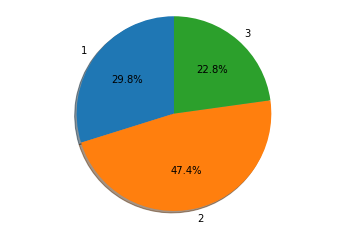

In [6]:
#The following is the distribution of the test set
#We want this to be similar to the dataset as a whole
import matplotlib.pyplot as plt

percentages= [np.count_nonzero(y_test==0),
              np.count_nonzero(y_test==1),
              np.count_nonzero(y_test==2)]
              
fig1, ax1 = plt.subplots()
ax1.pie(percentages,labels=["1","2","3"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

In [7]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional


'''
    No Re-used ReLU's in BasicBlock and BottleNeck. Local Imports modified for direct imports.

    TorchVision.models.resnet src modified from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

'''


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-63fe2227.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu1 = nn.ReLU(inplace=False)
        self.relu2 = nn.RelU(inplace=False)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu2(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu1 = nn.ReLU(inplace=False)
        self.relu2 = nn.ReLU(inplace=False)
        self.relu3 = nn.ReLU(inplace=False)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [8]:
#This is the classifier Class.
from torchvision.transforms.transforms import RandomRotation, RandomAdjustSharpness, RandomGrayscale

class Classifier(torch.nn.Module):

  def __init__(self, backbone='resnet', multi_backbone = False, device ="cuda:0",dropout_rate = 0.2, do_augmentation = False):
    super(Classifier, self).__init__()
    self.multi_backbone = multi_backbone # Bool: Indicates if we use multibackbone

    #In the following secttion we download the appropriatee prettrained model
    if backbone == "vgg19":
      backbone = torchvision.models.vgg19(pretrained=True)
      self.out_channels = 25088
      
    elif backbone == "resnet18":
      #backbone = torchvision.models.resnet18(pretrained=True)
      backbone = resnet18(pretrained=True)
      self.out_channels = 512

    elif backbone == "resnet50":
      #backbone = torchvision.models.resnet50(pretrained=True)
      backbone = resnet50(pretrained=True)
      self.out_channels = 2048

    elif backbone == "Efficientnet b1":
      backbone = torchvision.models.efficientnet_b1(pretrained=True)
      self.out_channels = 1280

    elif backbone == "Efficientnet b3":
      backbone = torchvision.models.efficientnet_b3(pretrained=True)
      self.out_channels = 1536

    elif backbone == "Efficientnet b5":
      backbone = torchvision.models.efficientnet_b5(pretrained=True)
      self.out_channels = 2048

    elif backbone == "Efficientnet b7":
      backbone = torchvision.models.efficientnet_b7(pretrained=True)
      self.out_channels = 2560
      
    # Disabling inplace ReLu becasuse GradCam doesn't work it enabled
    # reluToInplaceFalse(backbone)
     
    modules = list(backbone.children())[:-1]
    self.do_augmentation = do_augmentation

    if self.do_augmentation: #If augmentation is enabled we  init tthe layer
      self.augmentation = nn.Sequential(transforms.RandomHorizontalFlip(0.2),
                                        # transforms.RandomVerticalFlip(0.2),
                                        # transforms.RandomPerspective(0.2),
                                        RandomRotation(20),
                                        # RandomAdjustSharpness(,),
                                        # RandomGrayscale(),
                                        # transforms.RandomAutocontrast()
      )

    if self.multi_backbone: #We create the backbones and put them on the device
      self.backbone1 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone2 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone3 = nn.Sequential(*copy.deepcopy(modules)).to(device)
      self.backbone4 = nn.Sequential(*copy.deepcopy(modules)).to(device)

    else:
      self.backbone =  nn.Sequential(*modules).to(device)


     
    #This is the first fully connected layer
    #The output of the backbone goes through this layer before being concatnenated
    self.fc1 = nn.Sequential(nn.Dropout(dropout_rate),
                              nn.Linear(self.out_channels, 256), 
                              nn.ReLU(inplace=False),
                              nn.Dropout(dropout_rate)) #TODO: Experiment with BN and Dropout
    #This is the final classification layer
    self.fc = nn.Sequential(nn.Linear(1024, 256),
                            nn.ReLU(inplace=False),
                            nn.Dropout(dropout_rate),
                            nn.Linear(256, 3))                
     
  def forward(self, x, is_training = True): 
    if self.do_augmentation and is_training:
      imgs = [self.augmentation(x[:,i]) for i in range(4)] #list of 4 images
    else:
      imgs = [x[:,i] for i in range(4)] #list of 4 images

    if self.multi_backbone:
      encodings = [self.fc1(self.backbone1(imgs[0]).squeeze()), 
                   self.fc1(self.backbone2(imgs[1]).squeeze()),
                   self.fc1(self.backbone3(imgs[2]).squeeze()),
                   self.fc1(self.backbone4(imgs[3]).squeeze())]
    else:
      encodings = [self.fc1(self.backbone(img).squeeze()) for img in imgs]

    return self.fc(torch.cat(encodings,1))

In [9]:
#This functtion is responsibl for freezing the early layers of the backbone(s)
def freeze_layers(model,layers = 5):
  if model.multi_backbone:
    for i,param in enumerate(model.backbone1.parameters()):
      pass
    print("This Bacbone has {} parameter layers.".format(i))
    print("Freezing {} Layers.".format(layers))
    for i,param in enumerate(model.backbone1.parameters()):
      if i < layers:
        param.requires_grad = False

    for i,param in enumerate(model.backbone2.parameters()):
      if i < layers:
        param.requires_grad = False

    for i,param in enumerate(model.backbone3.parameters()):
      if i < layers:
        param.requires_grad = False

    for i,param in enumerate(model.backbone4.parameters()):
      if i < layers:
        param.requires_grad = False
  else:
     for i,param in enumerate(model.backbone.parameters()):
      if i < layers:
        param.requires_grad = False



In [10]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def train_model(model, train_dl, test_dl, optimizer, evaluation_steps = 20, epochs =1, savefile='model.sd'):
  writer = SummaryWriter()

  EPOCHS = epochs
  DATA_SIZE =  {"train":len(train_dl.dataset),"eval":len(test_dl.dataset)}

  best_eval_acc = 0
  best_eval_acc_step = 0
  
  best_eval_loss = float('inf')
  best_eval_loss_step = 0

  final_eval_loss = 0
  final_eval_acc = 0

  final_train_loss = 0
  final_train_acc = 0


  # exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  criterion = nn.BCEWithLogitsLoss() #This is the loss function we use
 
  step =0
  model.train()
  for epoch in range(EPOCHS):
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        model.train()
        for inputs, labels in train_dl: #Basic Training Loop
          optimizer.zero_grad() 
          step += 1
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)

          _, preds = torch.max(outputs, 1) 
          loss = criterion(outputs, labels.squeeze(1).float())
          loss.backward()
          optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == torch.argmax(labels,2).squeeze().data)
          # if phase == 'train':
          #     scheduler.step()
          if step % evaluation_steps == 0:
            test_running_loss = 0.0
            test_running_corrects = 0
            model.eval()
            with torch.no_grad():
              for inputs, labels in test_dl:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs,is_training=False)
                loss = criterion(outputs, labels.squeeze(1).float())
                _, preds = torch.max(outputs, 1)


                test_running_loss += loss.item() * inputs.size(0)
                test_running_corrects += torch.sum(preds == torch.argmax(labels,2).squeeze().data)
              #Put model back in training mode
              model.train()

            eval_loss = test_running_loss / DATA_SIZE["eval"]
            eval_acc = test_running_corrects.double() / DATA_SIZE["eval"]

            #We add the mettrics tto tensorboard
            writer.add_scalar('Loss/'+"eval", eval_loss, step)
            writer.add_scalar('Accuracy/'+"eval", eval_acc, step)

            final_eval_loss = eval_loss
            final_eval_acc = eval_acc

            if eval_loss < best_eval_loss:
              best_eval_loss = eval_loss
              best_eval_loss_step = step
              #torch.save(model, savefile)
              torch.save(model, savefile)

            if eval_acc > best_eval_acc:
              best_eval_acc = eval_acc
              best_eval_acc_step = step

            print("Step {} ".format(step),'{} Loss: {:.4f} Acc: {:.4f}'.format(
            "Eval", eval_loss, eval_acc))



        epoch_loss = running_loss / DATA_SIZE["train"]
        epoch_acc = running_corrects.double() / DATA_SIZE["train"]


        final_train_loss = epoch_loss
        final_train_acc = epoch_acc

        print('Epoch {}/{} '.format(epoch+1, EPOCHS ),'{} Loss: {:.4f} Acc: {:.4f}'.format(
              "Train", epoch_loss, epoch_acc))
          
        writer.add_scalar('Loss/'+"Train", epoch_loss, step)
        writer.add_scalar('Accuracy/'+"Train", epoch_acc, step)

  print('Best val Acc: {:4f}\n\n'.format(best_eval_acc))

  return {  "Best Eval Acc": best_eval_acc.cpu().item(),
            "Best Eval Loss": best_eval_loss,
            "Best Eval Step": best_eval_loss_step,
            "Final Train Acc": final_train_acc.cpu().item(),
            "Final Eval Acc": final_eval_acc.cpu().item(),
            "Final Train Loss": final_train_loss,
            "Final Eval Loss": final_eval_loss,
        }



In [11]:
#This is an example for training a model
BACKBONE = "resnet50"
# pass in a single backbone instance
model = Classifier(dropout_rate=0,backbone=BACKBONE,multi_backbone=False,do_augmentation=True).to(device)
freeze_layers(model,80)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_model(model,train_dl,test_dl,optimizer,epochs=10,savefile='resnet50_deeplift_singlebackbone_oriented.pt')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Step 20  Eval Loss: 0.6158 Acc: 0.4561
Step 40  Eval Loss: 0.6071 Acc: 0.4561
Epoch 1/10  Train Loss: 0.6067 Acc: 0.5614
Step 60  Eval Loss: 0.6191 Acc: 0.4561
Step 80  Eval Loss: 0.6136 Acc: 0.4561
Step 100  Eval Loss: 0.6146 Acc: 0.4561
Epoch 2/10  Train Loss: 0.5761 Acc: 0.5702
Step 120  Eval Loss: 0.6161 Acc: 0.4561
Step 140  Eval Loss: 0.6115 Acc: 0.4561
Step 160  Eval Loss: 0.6142 Acc: 0.4561
Epoch 3/10  Train Loss: 0.5716 Acc: 0.5702
Step 180  Eval Loss: 0.6264 Acc: 0.4561
Step 200  Eval Loss: 0.6027 Acc: 0.4561
Step 220  Eval Loss: 0.6198 Acc: 0.4561
Epoch 4/10  Train Loss: 0.5628 Acc: 0.5702
Step 240  Eval Loss: 0.6354 Acc: 0.4561
Step 260  Eval Loss: 0.6191 Acc: 0.4561
Step 280  Eval Loss: 0.6132 Acc: 0.4737
Epoch 5/10  Train Loss: 0.5486 Acc: 0.5789
Step 300  Eval Loss: 0.6795 Acc: 0.4561
Step 320  Eval Loss: 0.6698 Acc: 0.4561
Step 340  Eval Loss: 0.7498 Acc: 0.4737
Epoch 6/10  Train Loss: 0.5282 Acc: 0.5921
Step 360  Eval Loss: 0.6757 Acc: 0.4737
Step 380  Eval Loss: 0.653

{'Best Eval Acc': 0.49122807017543857,
 'Best Eval Loss': 0.5977098251643934,
 'Best Eval Step': 400,
 'Final Eval Acc': 0.45614035087719296,
 'Final Eval Loss': 0.7056880331875985,
 'Final Train Acc': 0.7017543859649122,
 'Final Train Loss': 0.448476386174821}

In [12]:
import torch.nn as nn

In [13]:
import pprint
pprint.pprint(vars(nn.ReLU()))

{'_backward_hooks': OrderedDict(),
 '_buffers': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_parameters': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 'inplace': False,
 'training': True}


In [14]:
import torch

def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [16]:
model_list = get_children(model)

In [22]:
model_list

[RandomHorizontalFlip(p=0.2),
 RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0),
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 ReLU(),
 ReLU(),
 Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Conv2d

In [23]:
model_list[4].type

<bound method Module.type of ReLU()>